In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

dataset = pd.read_csv("../data/logfile-storage-v4.csv", delimiter=";")
dataset.head()

,datacenter_id,datacenter_name,datacenter_storage_energy,storage_id,system,storage_capacity,capacity_used,active_duration,idle_intervals,duration,total_energy_active,total_energy_idle,average_rotation_latency,average_seek_Time,max_internal_data_transfer_rate,is_active,idle_power,active_power,files,Unnamed: 19
0,3,Datacenter_1,113716.350085,0,storage,900000.0,144384.0,745.127461,1.0000017892249078:,961.692048,4321.739273,3.000005,0.003,0.004,198.0,False,3.0,5.8,"55596,3072,15.519012736963932:1-55848,3072,15....",NaN
1,3,Datacenter_1,113716.350085,1,storage,900000.0,139776.0,721.881444,1.0000001822594735:,961.692048,4186.912375,3.000001,0.003,0.004,198.0,False,3.0,5.8,"3-55896,3072,15.518360641031068:2-572526,2560,...",NaN
2,3,Datacenter_1,113716.350085,2,storage,900000.0,145408.0,765.796667,1.000000266829021:,961.692048,4441.620671,3.000001,0.003,0.004,198.0,False,3.0,5.8,"1-450552,1024,5.183152612866157:6-753921,3072,...",NaN
3,3,Datacenter_1,113716.350085,3,storage,900000.0,169472.0,954.602773,1.0000002917759447:,961.692048,5536.696084,3.000001,0.003,0.004,198.0,False,3.0,5.8,"591399,3072,15.520055166649824:288827,512,2.59...",NaN
4,3,Datacenter_1,113716.350085,4,storage,900000.0,168448.0,856.300420,1.0000004167879113:,961.692048,4966.542439,3.000001,0.003,0.004,198.0,False,3.0,5.8,"25-240840,3072,15.526928354068726:1-878247,102...",NaN


### Storage placement

#### Current data placement

In [2]:
labels = np.unique(dataset['datacenter_name'])
files_per_datacenter = np.array([])
files_per_host = np.array([])
for i in range(len(labels)):
    files_per_datacenter_per_host = np.array([])
    
    for index, sample in dataset[dataset['datacenter_name'] == labels[i]].iterrows():
        if pd.notna(sample['files']):
            files = len(sample['files'].split(":"))-1
            print(f"Disk ID '{sample['storage_id']}' at datacenter '{sample['datacenter_name']}' has {files} stored files.")
            files_per_host = np.append(files_per_host, files)
            files_per_datacenter_per_host = np.append(files_per_datacenter_per_host, files)
    files_per_datacenter = np.append(files_per_datacenter, sum(files_per_datacenter_per_host))

for i in range(len(labels)):
    print(f"{files_per_datacenter[i]} stored files at datacenter '{labels[i]}'.")
print(f"The cloud provider has {sum(files_per_datacenter)} stored files.")


Disk ID '0' at datacenter 'Datacenter_1' has 55 stored files.
Disk ID '1' at datacenter 'Datacenter_1' has 55 stored files.
Disk ID '2' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '3' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '4' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '5' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '6' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '7' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '8' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '9' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '10' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '11' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '12' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '13' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '14' at datacenter 'Datacenter_1' has 54 stored files.
Disk ID '0' at datacenter 'Datacenter_2' has 1 stored files.
Disk

#### Capacity aware data placement 

In [3]:

disks = []
files = []
for i, sample in dataset.iterrows():
    disks.append({
        "id": i,
        "datacenter": sample['datacenter_name'],
        "storage_capacity": float(sample['storage_capacity']),
        "capacity_used": float(sample['capacity_used']),
        "active_power": float(sample['active_power']),
        "idle_power": float(sample['idle_power'])

    })
    if pd.notna(sample['files']):
        for j, file in enumerate(sample['files'].split(":")):
            file_data = file.split(",")
            if len(file_data) != 3:
                continue
            files.append({
                "id": j,
                "filename": file_data[0],
                "filesize": float(file_data[1]),
                "transaction_time": float(file_data[2])
            })

files_copy = files.copy()
new_storage_placement = []
removed_files_from_copy = 0

for index_disk, disk in enumerate(disks):
    used_storage = 0
    files_per_disk = []
    for file in files_copy:
        if file['filesize'] + used_storage <= disk['storage_capacity']:
            used_storage += file['filesize']
            files_per_disk.append(file)
    
    # Adding to new list of placement of data and removing from the copy 
    new_storage_placement.append(files_per_disk)
    for index, file in enumerate(files_per_disk):
        run = True
        index = 0
        while run:
            if file['id'] == files_copy[index]['id']:
                del files_copy[index]
                run = False
            index += 1


Disk ID '0' has 331 stored files with capacity (899584.0/900000.0) as supposed to (144384.0/900000.0),
consuming the 26043.930489085145 over the duration 4490.332842945715s,
where the disk was idle for 0.0 which could have saved 0.0 if powered off.

Disk ID '1' has 280 stored files with capacity (899584.0/900000.0) as supposed to (139776.0/900000.0),
consuming the 25152.64921440526 over the duration 4490.332842945715s,
where the disk was idle for 318.3147409571011 which could have saved 954.9442228713033 if powered off.

Disk ID '2' has 204 stored files with capacity (636416.0/900000.0) as supposed to (145408.0/900000.0),
consuming the 21777.176871998694 over the duration 4490.332842945715s,
where the disk was idle for 1523.8405775308765 which could have saved 4571.52173259263 if powered off.

Disk ID '3' has 0 stored files with capacity (0/900000.0) as supposed to (169472.0/900000.0),
can be powered off consuming 0 Joules (J) over the duration 4490.332842945715s.

Disk ID '4' has 0 st

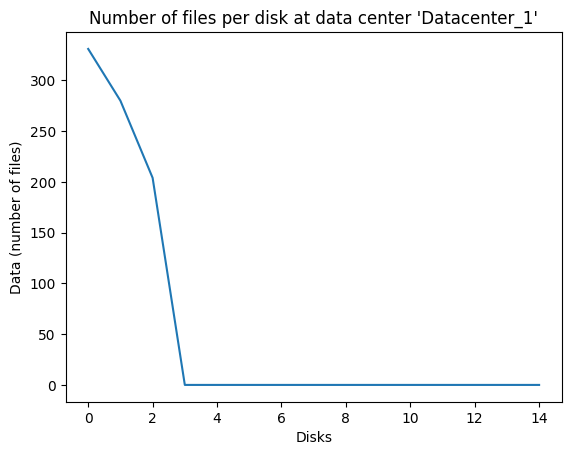

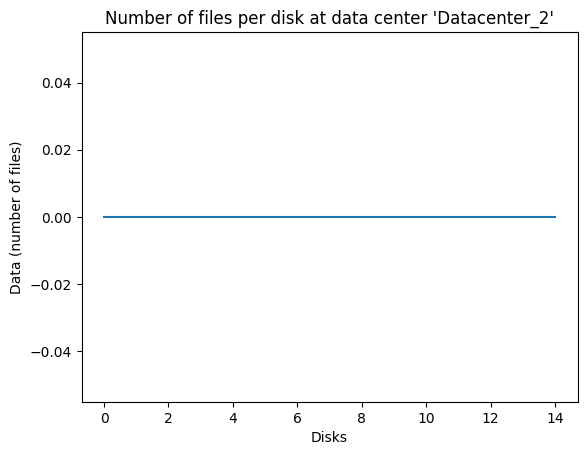

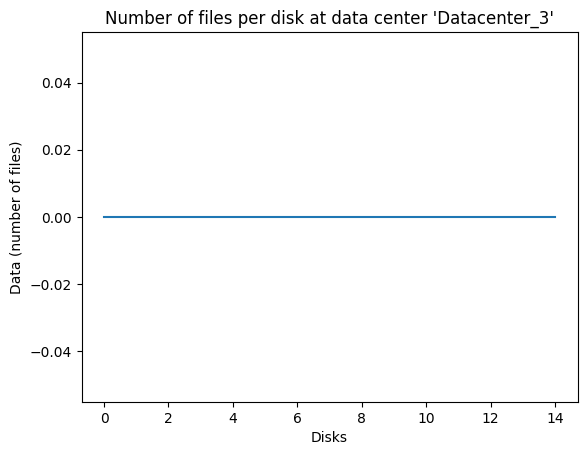

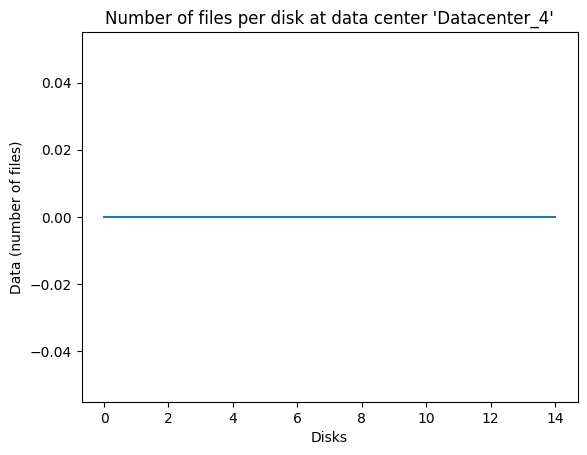

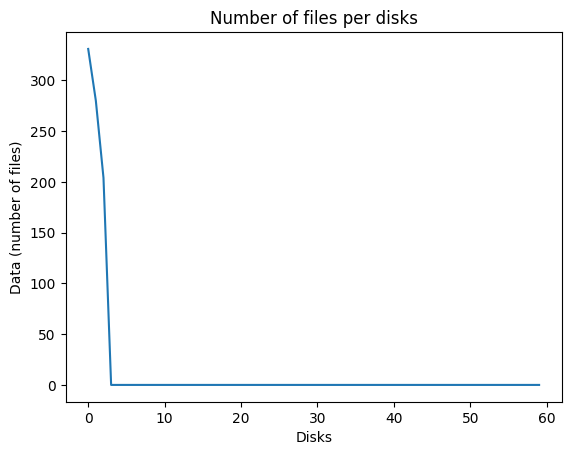

In [4]:
# Getting new duration
max_time = 0
for index_disk, disk in enumerate(new_storage_placement):
    transaction_time = 0
    for index_file, file in enumerate(disk):
        transaction_time += file['transaction_time']
    if transaction_time > max_time:
        max_time += transaction_time

# Calculating the capacity used per disk and power consumption.
new_data_placement_per_disk = np.array([])
new_data_placement_per_datacenter_per_disk = {}
for index_disk, disk in enumerate(new_storage_placement):
    transaction_time = 0
    capacity_used = 0
    files = len(disk)
    
    for index_file, file in enumerate(disk):
        capacity_used += file['filesize']
        transaction_time += file['transaction_time']
    
    
    new_data_placement_per_disk = np.append(new_data_placement_per_disk, files)
    if disks[index_disk]['datacenter'] not in new_data_placement_per_datacenter_per_disk.keys():
        # print(new_data_placement_per_datacenter_per_disk[hosts[index_host]['datacenter']])
        new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']] = np.array([])
    new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']] = np.append(new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']], files)
    
    
    if files != 0:
        print(f"Disk ID '{index_disk}' has {files} stored files with capacity ({capacity_used}/{disks[index_disk]['storage_capacity']}) as supposed to ({disks[index_disk]['capacity_used']}/{disks[index_disk]['storage_capacity']}),\nconsuming the {(disks[index_disk]['active_power']*transaction_time) + (disks[index_disk]['idle_power']*(max_time - transaction_time))} over the duration {max_time}s,\nwhere the disk was idle for {max_time - transaction_time} which could have saved {disks[index_disk]['idle_power']*(max_time - transaction_time)} if powered off.\n")
    else:
        print(f"Disk ID '{index_disk}' has {files} stored files with capacity ({capacity_used}/{disks[index_disk]['storage_capacity']}) as supposed to ({disks[index_disk]['capacity_used']}/{disks[index_disk]['storage_capacity']}),\ncan be powered off consuming 0 Joules (J) over the duration {max_time}s.\n")

for key in new_data_placement_per_datacenter_per_disk.keys():
    plt.plot(np.arange(len(new_data_placement_per_datacenter_per_disk[key])), new_data_placement_per_datacenter_per_disk[key], label="Files per host")
    plt.xlabel("Disks")
    plt.ylabel("Data (number of files)")
    plt.title(f"Number of files per disk at data center '{key}'")
    #plt.legend()
    plt.show()

plt.plot(np.arange(len(new_data_placement_per_disk)), new_data_placement_per_disk, label="Files per host")
plt.xlabel("Disks")
plt.ylabel("Data (number of files)")
plt.title("Number of files per disks")
#plt.legend()
plt.show()

#### Optimal capacity aware storage placement 

### Re-organization of file placement

Rebalancing over utilized and under utilized disk capacity with the goal if better utilizing the storage area network.

In [5]:
labels = np.unique(dataset['datacenter_name'])
files_reorganized = []
disks_reorganized = []

files_to_reallocate = np.array([])
over_utilized_disks = 0
under_utilized_disks = 0

for i in range(len(labels)):
    for index, sample in dataset[dataset['datacenter_name'] == labels[i]].iterrows():
        files_temp = []
        if pd.notna(sample['files']):
            for index_file, file in enumerate(sample['files'].split(":")):
                    if file != "":
                        file_data = file.split(",")
                        files_temp.append({
                            "id": j,
                            "filename": file_data[0],
                            "filesize": float(file_data[1]),
                            "transaction_time": float(file_data[2])
                        })
        
        # check if host is over utilized
        capacity_utilization = sample['capacity_used'] / sample['storage_capacity']
        
        if capacity_utilization > 0.9:
            over_utilized_disks += 1
            if pd.notna(sample['vms']):
                run = True
                for index_file, file in enumerate(sample['files'].split(":")):
                    if run == True and file != "":
                        file_data = file.split(",")
                        capacity_utilization = (sample['capacity_used'] - float(file_data[1])) / sample['storage_capacity']
                        
                        
                        if capacity_utilization >= 0.8 and capacity_utilization < 0.9:
                            files_to_reallocate.append(files_temp[index_file])
                            del files_temp[index_file]
                            run = False
        elif capacity_utilization == 0:
            pass
        elif capacity_utilization < 0.8:
            under_utilized_disks += 1
            
    
        disks_reorganized.append({
            "id": i,
            "datacenter": sample['datacenter_name'],
            "storage_capacity": float(sample['storage_capacity']),
            "capacity_used": float(sample['capacity_used']),
            "active_power": float(sample['active_power']),
            "idle_power": float(sample['idle_power']),
            "files": files_temp
        })
print(f"There were {over_utilized_disks} over utilized disks")
print(f"There were {under_utilized_disks} under utilized disks")

# Re allocating files
for disk in disks_reorganized:
    capacity_utilization = disk['capacity_used'] / disk['storage_capacity']
    new_capacity_used = disk['capacity_used']
    new_allocated_files = disk['files']
    if capacity_utilization <= 0.8:
        for index_file, file in enumerate(files_to_reallocate):
            temp_capacity_used = new_capacity_used
            temp_capacity_used += file['filesize']
            if (temp_capacity_used / disk['storage_capacity']) <= 0.8:
                new_capacity_used += file['filesize']
                new_allocated_files.append(file)
                del files_to_reallocate[index_file]
        disk['capacity_used'] = new_capacity_used
        disk['files'] = new_allocated_files

# consolidate under utilized disks


There were 0 over utilized disks
There were 18 under utilized disks
